In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import pyfolio as pf
warnings.simplefilter('ignore')

# Accelerating Dual Momentum

This momentum-based asset allocation strategy allocates 100% of the portfolio to one asset each month. The strategy uses the momentum score to determine the allocation.

### 1. Asset Universe

Define the universe of assets as:
- **Equities:** $A_{equity} = \{SPY, SCZ\}$
- **Bonds:** $A_{bonds} = \{TLT, TIP\}$

### 2. Momentum Score Calculation

On the last trading day of each month, calculate the momentum score for each asset in $A_{equity}$.

#### Formula for Momentum Score:

For asset $i$ at time $t$:
$$
\text{Momentum Score}_{i,t} = \frac{1}{3} \left( \frac{P_{i,t}}{P_{i,t-1}} - 1 + \frac{P_{i,t}}{P_{i,t-3}} - 1 + \frac{P_{i,t}}{P_{i,t-6}} - 1 \right)
$$

where:
- $P_{i,t}$ is the price of asset $i$ at time $t$
- $P_{i,t-1}$ is the price of asset $i$ at the close of last month
- $P_{i,t-3}$ is the price of asset $i$ at the close of three months ago
- $P_{i,t-6}$ is the price of asset $i$ at the close of six months ago

### 3. Allocation Rules

1. **Compare Momentum Scores:**
   - If $\text{Momentum Score}_{SCZ} > \text{Momentum Score}_{SPY}$ and $\text{Momentum Score}_{SCZ} > 0$, invest 100% in $SCZ$.
   - If $\text{Momentum Score}_{SPY} > \text{Momentum Score}_{SCZ}$ and $\text{Momentum Score}_{SPY} > 0$, invest 100% in $SPY$.
   
2. **If Neither Momentum Score is Greater Than 0:**
   - Calculate the 1-month total return for $TLT$ and $TIP$:
     $$
     \text{Return}_{i,t} = \frac{P_{i,t}}{P_{i,t-1}} - 1
     $$
   - Invest 100% in the asset with the higher 1-month total return.

### 4. Portfolio Rebalancing

Rebalance the portfolio monthly according to the above rules:
$$
\text{Allocation}_{t} = \begin{cases}
SCZ, & \text{if } \text{Momentum Score}_{SCZ} > \text{Momentum Score}_{SPY} \text{ and } \text{Momentum Score}_{SCZ} > 0 \\
SPY, & \text{if } \text{Momentum Score}_{SPY} > \text{Momentum Score}_{SCZ} \text{ and } \text{Momentum Score}_{SPY} > 0 \\
TLT \text{ or } TIP, & \text{if } \text{Momentum Scores of } SCZ \text{ and } SPY \text{ are both} \leq 0
\end{cases}
$$

### Summary

The momentum-based asset allocation strategy dynamically adjusts the portfolio by:
1. Calculating a momentum score for each equity asset.
2. Allocating 100% of the portfolio to the asset with the higher positive momentum score.
3. If neither equity asset has a positive momentum score, allocating 100% to the bond asset with the higher 1-month return.
4. Rebalancing monthly to adapt to changing market conditions.


[*********************100%%**********************]  4 of 4 completed
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


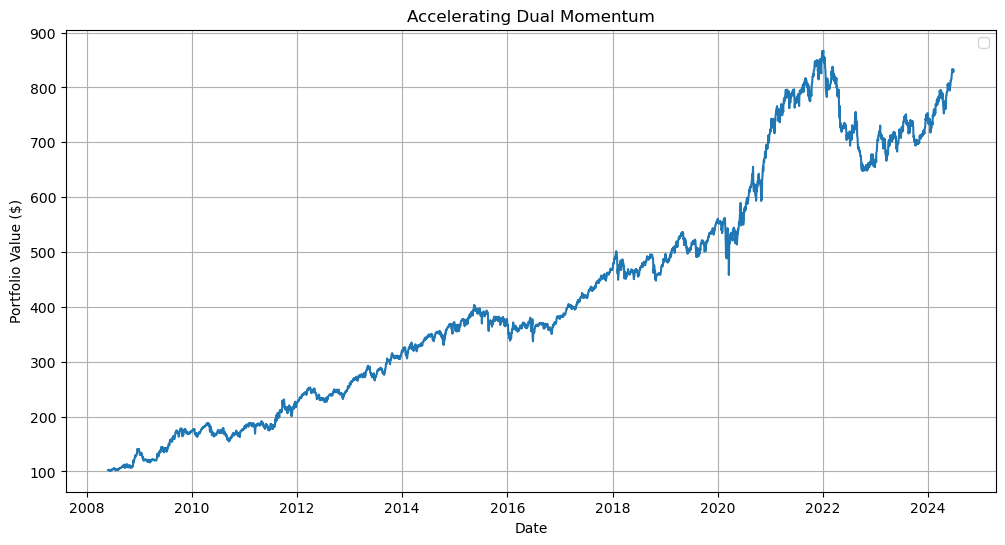

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define assets
equities = ['SPY', 'SCZ']
bonds = ['TLT', 'TIP']
assets = equities + bonds

# Download data
data = yf.download(assets, start="2007-06-01")['Adj Close']
monthly_prices = data.resample('BM').last()
returns = monthly_prices.pct_change()

# Function to calculate momentum score
def calculate_momentum_score(prices):
    p0 = prices.iloc[-1]
    p1 = prices.iloc[-2]
    p3 = prices.iloc[-4]
    p6 = prices.iloc[-7]
    momentum_score = (p0/p1 + p0/p3 + p0/p6)/3 - 1
    return momentum_score

# Initialize the allocations DataFrame
allocations = pd.DataFrame(index=monthly_prices.index, columns=assets).fillna(0)

# Perform monthly rebalancing
for date in monthly_prices.index[6:]:
    momentum_scores = {}
    for equity in equities:
        momentum_scores[equity] = calculate_momentum_score(monthly_prices.loc[:date, equity])
    
    if momentum_scores['SCZ'] > momentum_scores['SPY'] and momentum_scores['SCZ'] > 0:
        allocations.loc[date, 'SCZ'] = 1.0
    elif momentum_scores['SPY'] > momentum_scores['SCZ'] and momentum_scores['SPY'] > 0:
        allocations.loc[date, 'SPY'] = 1.0
    else:
        bond_returns = returns.loc[date, bonds]
        if bond_returns['TLT'] > bond_returns['TIP']:
            allocations.loc[date, 'TLT'] = 1.0
        else:
            allocations.loc[date, 'TIP'] = 1.0

# Forward fill allocations to daily frequency
daily_allocations = allocations.reindex(data.index, method='ffill')

# Calculate daily returns of the strategy
strategy_daily_returns = (daily_allocations.shift(1) * data.pct_change()).sum(axis=1)

# Define initial investment
initial_investment = 100

# Calculate the cumulative returns of the strategy
strategy_cumulative_returns = (1 + strategy_daily_returns).cumprod()

# Calculate the portfolio value over time
portfolio_value = strategy_cumulative_returns * initial_investment

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:])
plt.title('Accelerating Dual Momentum')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


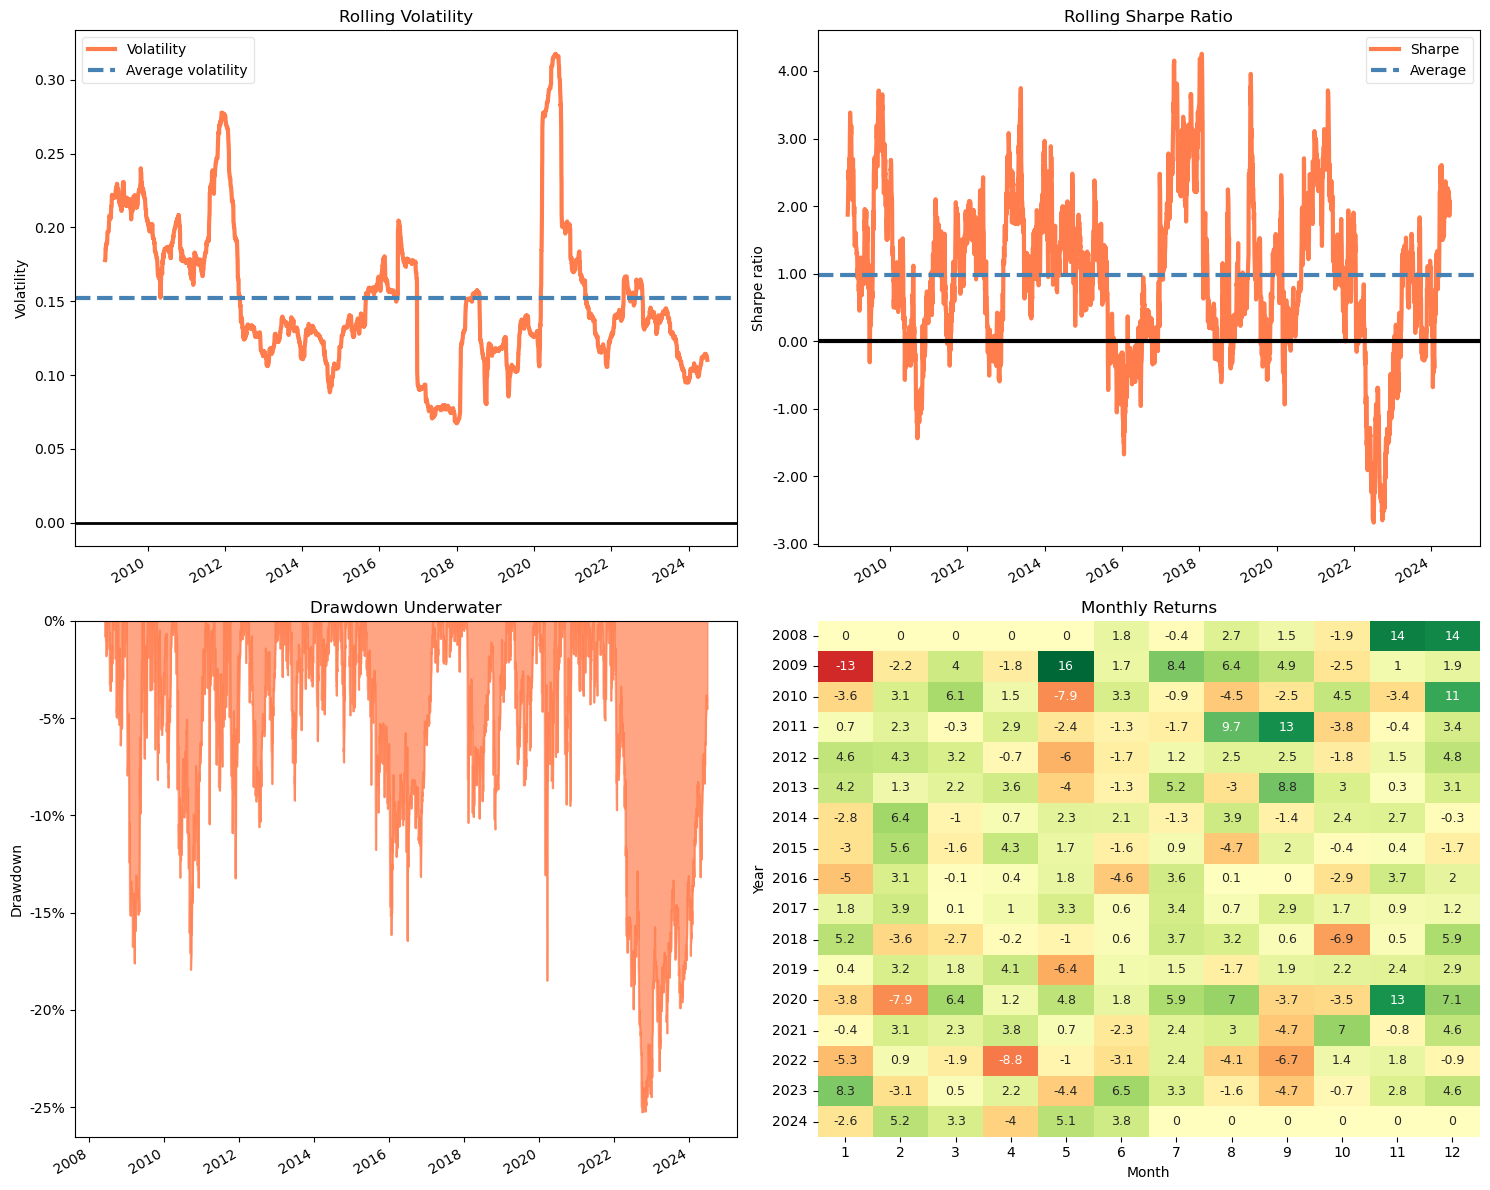

Annual return          0.139408
Cumulative returns     7.124362
Annual volatility      0.158866
Sharpe ratio           0.901269
Calmar ratio           0.551834
Stability              0.952534
Max drawdown          -0.252626
Omega ratio            1.174660
Sortino ratio          1.287496
Skew                  -0.292253
Kurtosis               5.286502
Tail ratio             0.982784
Daily value at risk   -0.019447
dtype: float64


In [16]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)